In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from numpy import random as npr
from math import gamma
from math import factorial
from sobol_seq import sobol_seq
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0')

In [3]:
n_collocation = 1000
n_validation = 1000
n_initial = 100
n_boundary = 100
x_lower = 0
x_upper = 1
e = torch.tensor(2**-7).to(device)

def analytical(x):
    return (torch.exp(-x) - torch.exp(-x/e))/(torch.exp(torch.tensor(-1)) - torch.exp(-1/e))

# Collocation points (random interior points)
sobol_sequence = sobol_seq.i4_sobol_generate(1,n_collocation)
x_collocation = torch.tensor(sobol_sequence.flatten().tolist()).reshape(n_collocation).to(device)
x_validation = (torch.rand(n_collocation) * (x_upper - x_lower) + x_lower).to(device)


x_bc0 = torch.zeros(n_initial).to(device)
x_bc1 = torch.ones(n_initial).to(device)
u_bc0 = analytical(x_bc0) 
u_bc1 = analytical(x_bc1)


exact = analytical(x_validation)

In [4]:

# Gaussian Wavelet
def wavelet(x,j,k):
    return -(j*x - k)*torch.exp(-((j*x - k)**2)/2)

def D1wavelet(x,j,k):
    return j*((j*x - k)**2 - 1)*torch.exp(-((j*x - k)**2)/2)

def D2wavelet(x,j,k):
    return (j**2)*(j*x - k)*(3 - (j*x - k)**2)*torch.exp(-((j*x - k)**2)/2)

'''
# Mexican hat Wavelet
def wavelet(x,j,k):
    return ((1-(j*x-k)**2)*torch.exp(-((j*x-k)**2)/2))

def D1wavelet(x,j,k):
    return -j*(j*x-k)*(3-(j*x-k)**2)*torch.exp(-((j*x-k)**2)/2)

def D2wavelet(x,j,k):
    return -j**2*(3-6*(j*x-k)**2+(j*x-k)**4)*torch.exp(-((j*x-k)**2)/2)
'''



# J = torch.tensor(11) #for mex
J = torch.arange(0,10)

family = torch.tensor([(2**j,k) for j in J for k in range(-int(2**(j-2)),int(2**(j+1)))])
print(len(family))


Wfamily = torch.stack([wavelet(x_collocation,family[i,0],family[i,1]) for i in range(len(family))]).T
DWx = torch.stack([D1wavelet(x_collocation,family[i,0],family[i,1]) for i in range(len(family))]).T
DW2x = torch.stack([D2wavelet(x_collocation,family[i,0],family[i,1]) for i in range(len(family))]).T

Wbc0 = torch.stack([wavelet(x_bc0,family[i,0],family[i,1]) for i in range(len(family))]).T
Wbc1 = torch.stack([wavelet(x_bc1,family[i,0],family[i,1]) for i in range(len(family))]).T

Wval = torch.stack([wavelet(x_validation,family[i,0],family[i,1]) for i in range(len(family))]).T
    

2301


In [5]:
class Model(nn.Module):
    def __init__(self, input_size = n_collocation, 
                 num_hidden_layers = 6, 
                 hidden_neurons = 100, 
                 family_size = len(family)):
        
        super(Model, self).__init__()
        
        self.activation = nn.Sigmoid()
        
        layers = []
        
        # Input size is now just input_size (number of points) since each point has 1 feature
        layers.append(nn.Linear(input_size, hidden_neurons))
        layers.append(self.activation)
        
        for _ in range(num_hidden_layers):  # Fewer layers in second stage
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(self.activation)
        
        # Final layer outputs the wavelet coefficients
        layers.append(nn.Linear(hidden_neurons, family_size))
        self.trainable_network = nn.Sequential(*layers)
        
        # Initialize weights
        for m in self.trainable_network:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)
        
        # Output layers for the different derivatives
        self.output_layers = nn.ModuleList()
        for i in range(3):
            output_layer = nn.Linear(family_size, 1)
            output_layer.weight.requires_grad = False
            output_layer.bias.data = torch.tensor(0.0 if i > 0 else 0.5)
            output_layer.bias.requires_grad = i == 0
            self.output_layers.append(output_layer)

    def forward(self, x, W):

        inp = x.reshape(1,n_collocation)
        coefficients = self.trainable_network(inp)  # Shape: [family_size]
        
        # Generate outputs using the wavelet family
        outputs = []
        for i, layer in enumerate(self.output_layers):
            layer.weight.data = W[i]
            outputs.append(layer(coefficients).reshape(-1))

        bias = self.output_layers[0].bias.data
        
        return coefficients.squeeze(), bias, outputs
        

model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=10**-4)
# beta = 0.9
# optimizer1 = optim.Adam(model.parameters(), lr=0.00001, betas=(beta, 0.999))

c, b, u = model(x_collocation, [Wfamily, DWx, DW2x])
u[0].shape

torch.Size([1000])

In [6]:
def compute_pinn_loss():

    global c, b
    c, b, u = model(x_collocation, [Wfamily, DWx, DW2x])
    
    pde_loss = torch.mean((e*u[2] + (1+e)*u[1] + u[0]) ** 2)
    
    # Initial condition loss
    # u_pred_ic = model(t_ic, [Wic, DWic, DWic])
    u_pred_bc0 = torch.mv(Wbc0, c) + b
    u_pred_bc1 = torch.mv(Wbc1, c) + b
    
    bc_loss0 = torch.mean((u_pred_bc0 - u_bc0) ** 2)
    bc_loss1 = torch.mean((u_pred_bc1 - u_bc1) ** 2)
    
    total_loss = pde_loss + bc_loss0 + bc_loss1
    
    return total_loss, pde_loss    #, pde_loss, ic_loss, bc_loss

def train_pinn():
    # Training loop
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        total_loss, pde_loss = compute_pinn_loss()
        
        total_loss.backward()
        optimizer.step()
        
        losses.append(pde_loss.item())
        
        if (epoch) % 1000 == 0:

            # numerical = model(t_validation, [Wval]*3)[0]
            numerical = torch.mv(Wval, c) + b
  
            errL2 = (torch.sum(torch.abs(exact-numerical)**2))**0.5 / (torch.sum(torch.abs(exact)**2))**0.5
            errMax = torch.max(torch.abs(exact-numerical))
            
            print(f'Epoch [{epoch}/{num_epochs-1}], '
                  f'Total Loss: {total_loss.item():.6f},\t\t '
                  f'RelativeL2: {errL2},\t\t'
                  f'Max: {errMax}\n' )
    
    return losses

In [7]:
num_epochs = 2*10**4+1

# Train the model
losses = train_pinn()

Epoch [0/20000], Total Loss: 376635.625000,		 RelativeL2: 0.6998628377914429,		Max: 2.426898956298828

Epoch [1000/20000], Total Loss: 0.318359,		 RelativeL2: 0.6096674203872681,		Max: 1.6765573024749756

Epoch [2000/20000], Total Loss: 0.049580,		 RelativeL2: 0.2299814522266388,		Max: 0.6326515674591064

Epoch [3000/20000], Total Loss: 0.005607,		 RelativeL2: 0.04272434860467911,		Max: 0.1176292896270752

Epoch [4000/20000], Total Loss: 0.049537,		 RelativeL2: 0.0023801601491868496,		Max: 0.0067632198333740234

Epoch [5000/20000], Total Loss: 0.065252,		 RelativeL2: 0.0001312742824666202,		Max: 0.0024544596672058105

Epoch [6000/20000], Total Loss: 0.012459,		 RelativeL2: 0.00012523331679403782,		Max: 0.002448856830596924

Epoch [7000/20000], Total Loss: 0.522015,		 RelativeL2: 0.00025430539972148836,		Max: 0.0024620890617370605

Epoch [8000/20000], Total Loss: 0.164577,		 RelativeL2: 0.00022574569447897375,		Max: 0.0022528767585754395



KeyboardInterrupt: 

tensor(0.0039)


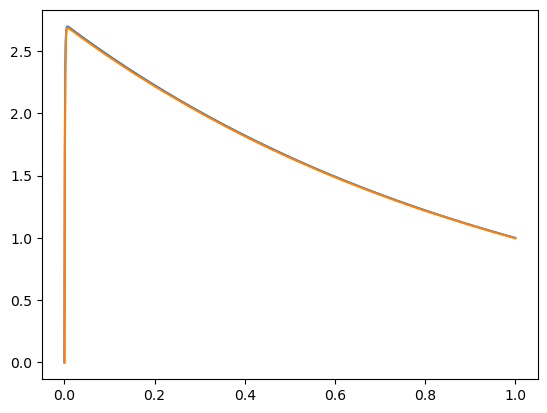

In [16]:
e = e.cpu()
ttest = torch.linspace(0,1,n_validation)
Wtest = torch.stack([wavelet(ttest,family[i,0],family[i,1]) for i in range(len(family))]).T.to(device)

exacttest = analytical(ttest)

pred = (torch.mv(Wtest, c) + b).cpu().detach().numpy()
errL2 = (torch.sum(torch.abs(exacttest-pred)**2))**0.5 / (torch.sum(torch.abs(exacttest)**2))**0.5
print(errL2)

plt.plot(ttest, exacttest)
plt.plot(ttest, pred)

plt.show()